In [ ]:
pip install ta==0.4.7

In [1]:
import glob
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt

from ta import add_all_ta_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Get csv/model filenames into variables

In [2]:
# Modify to your filepath for data

# csv path for models
csv_paths = glob.glob('data/*.csv') 

# model paths for trade recommender
model_paths = glob.glob('tr_pickles/*.pkl')

len(csv_paths), len(model_paths)

(9, 9)

### Function for feature engineering

In [3]:
def feature_engineering(df, period):
    """Takes in a dataframe of 5 minute cryptocurrency trading data
        and returns a new dataframe with 1 hour data and new technical analysis features:
    """
    
    # Add a datetime column to df
    df['date'] = pd.to_datetime(df['closing_time'], unit='s')
     
    # Convert df to one hour candles
    df = change_ohlcv_time(df, period)
    
    # Add feature to indicate user inactivity.
    df['nan_ohlc'] = df['close'].apply(lambda x: 1 if pd.isnull(x) else 0)
    
    # Fill in missing values using fill function.
    df = fill_nan(df)
    
    # Reset index.
    df = df.reset_index()
    
    # Create additional date features.
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    
    # Add technical analysis features.
    df = add_all_ta_features(df, "open", "high", "low", "close", "base_volume")
      
    # Replace infinite values with NaNs.
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Drop any features whose mean of missing values is greater than 20%.
    df = df[df.columns[df.isnull().mean() < .2]]
    
    # Replace remaining NaN values with the mean of each respective column and reset index.
    df = df.apply(lambda x: x.fillna(x.mean()),axis=0)
    
    # Create a feature for close price difference 
    df['close_diff'] = (df['close'] - df['close'].shift(1))/df['close'].shift(1)
    
    # Function to create target
    def price_increase(x):
        if (x-(.70/100)) > 0:
            return True
        else:
            return False
    
    # Create target
    target = df['close_diff'].apply(price_increase)
    
    # To make the prediction before it happens, put target on the next observation
    target = target[1:].values
    df = df[:-1]
    
    # Create target column
    df['target'] = target
    
    # Remove first row of dataframe bc it has a null target
    df = df[1:]
    
    # Pick features
    features = ['open', 'high', 'low', 'close', 'base_volume', 'nan_ohlc', 
                'year', 'month', 'day', 'volume_adi', 'volume_obv', 'volume_cmf', 
                'volume_fi', 'volume_em', 'volume_vpt', 'volume_nvi', 'volatility_atr', 
                'volatility_bbh', 'volatility_bbl', 'volatility_bbm', 'volatility_bbhi', 
                'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 
                'volatility_kchi', 'volatility_kcli', 'volatility_dch', 'volatility_dcl', 
                'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal', 
                'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 
                'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos', 
                'trend_vortex_ind_neg', 'trend_vortex_diff', 'trend_trix', 
                'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst', 
                'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a', 
                'trend_ichimoku_b', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 
                'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'momentum_rsi', 
                'momentum_mfi', 'momentum_tsi', 'momentum_uo', 'momentum_stoch', 
                'momentum_stoch_signal', 'momentum_wr', 'momentum_ao',  
                'others_dr', 'others_dlr', 'others_cr', 'close_diff', 'date', 'target']
    
    df = df[features]
    
    return df

### Function to change time period

In [4]:
def change_ohlcv_time(df, period):
    """ Changes the time period on cryptocurrency ohlcv data.
        Period is a string denoted by 'time_in_minutesT'(ex: '1T', '5T', '60T')."""

    # Set date as the index. This is needed for the function to run
    df = df.set_index(['date'])

    # Aggregation function
    ohlc_dict = {                                                                                                             
    'open':'first',                                                                                                    
    'high':'max',                                                                                                       
    'low':'min',                                                                                                        
    'close': 'last',                                                                                                    
    'base_volume': 'sum'
    }

    # Apply resampling.
    df = df.resample(period, how=ohlc_dict, closed='left', label='left')
    
    return df

### Function to fill nans

In [5]:
def fill_nan(df):
  
    '''Iterates through a dataframe and fills NaNs with appropriate open, high, low, close values.'''

    # Forward fill close column.
    df['close'] = df['close'].ffill()

    # Backward fill the open, high, low rows with the close value.
    df = df.bfill(axis=1)

    return df

### Function to calculate performance

In [6]:
def performance(X_test, y_preds):
    """ Takes in a test dataset and a model's predictions, calculates and returns
        the profit or loss """
    
    fee_rate = 0.35 
    
    #creates dataframe for features and predictions
    df_preds = X_test
    df_preds['y_preds'] = y_preds
    
    #creates column with 0s for False predictions and 1s for True predictions
    df_preds['binary_y_preds'] = df_preds['y_preds'].shift(1).apply(lambda x: 1 if x == True else 0)
    
    #performance results from adding the closing difference percentage of the rows where trades were executed
    performance = ((10000 * df_preds['binary_y_preds']*df_preds['close_diff']).sum())
    
    #calculating fees and improve trading strategy
    #creates a count list for when trades were triggered
    df_preds['preds_count'] = df_preds['binary_y_preds'].cumsum()
    
    #feature that determines the instance of whether the list increased
    df_preds['increase_count'] = df_preds['preds_count'].diff(1)
    
    #results in a feature that creates signal of when to buy(1), hold(0), or sell(-1)
    df_preds['trade_trig'] = df_preds['increase_count'].diff(1)
    
    #this is just the number of total entries(1s)
    number_of_entries = (df_preds.trade_trig.values==1).sum()
    
    #performance takes into account fees given the rate at the beginning of this function
    pct_performance = ((df_preds['binary_y_preds']*df_preds['close_diff']).sum())
    
    #calculate the percentage paid in fees
    fees_pct = number_of_entries * 2 * fee_rate/100
    
    #calculate fees in USD 
    fees = (df_preds.trade_trig.values==1).sum() * 2 * fee_rate / 100 * 10000
    
    #calculate net profit in USD
    performance_net = performance - fees
    
    #calculate net profit percent
    performance_net_pct = performance_net/10000

    return pct_performance, performance, fees, performance_net, performance_net_pct, df_preds

In [8]:
models = ['hitbtc_eth_usdt', 'bitfinex_ltc_usd', 'bitfinex_btc_usd',
          'hitbtc_ltc_usdt', 'coinbase_pro_btc_usd', 'coinbase_pro_ltc_usd',
          'coinbase_pro_eth_usd', 'bitfinex_eth_usd', 'hitbtc_btc_usdt']


periods = ['1440T', '720T', '960T', '1440T', '1440T', '960T', '720T', '720T',
           '1440T']

model_periods = {'bitfinex_ltc_usd': '1440T',
                 'bitfinex_btc_usd':'1200T',
                 'bitfinex_eth_usd': '1200T',
                 'hitbtc_ltc_usdt': '1440T',
                 'hitbtc_btc_usdt': '360T', 
                 'hitbtc_eth_usdt': '1440T',
                 'coinbase_pro_btc_usd': '960T', 
                 'coinbase_pro_eth_usd': '960T', 
                 'coinbase_pro_ltc_usd': '960T'}


# Creating DF to make visuals for model performance

In [9]:
def profit(csv_paths, model_paths, model_periods):
    
    df_dict = {}
    
    for model_path in model_paths:
        model_name = model_path.split('/')[1][:-4]
        period = model_periods[model_name]
        
        for csv_path in csv_paths:
            csv_name = csv_path.split('/')[1][:-9]
            
            if csv_name == model_name:
                
                df = pd.read_csv(csv_path, index_col=0)

                # engineer features
                df = feature_engineering(df, period)

                # create test set
                test = df[df['date'] > '2019-01-01 23:00:00'] # cutoff jan 01 2019
#                 print('{space} test data rows:'.format(space=space1), test.shape[0])
#                 print('{space} test data features:'.format(space=space2), test.shape[1])

                # features and target
                features = df.drop(columns=['target', 'date']).columns.tolist()
                features_w_date = df.drop(columns=['target']).columns.tolist()
                target = 'target'

                # define X, y vectors
                X_test = test[features]
                y_test = test[target]

                # load model
                loaded_model = pickle.load(open(model_path, 'rb'))

                # make predictions
                y_preds = loaded_model.predict(X_test)
                
                # create new df for performance 
                df = test[features_w_date]
                
                _,_,_,_,_,df = performance(df, y_preds)
                # making new df for testing
                df = df[['date', 'open', 'close', 'close_diff', 'y_preds', 'binary_y_preds', 'preds_count', 'increase_count', 'trade_trig']].reset_index(drop=True)
                
                if df['binary_y_preds'].loc[1] == 1:
                    df['trade_trig'].loc[1] = 1
                
                # create profit indicator to help make other columns
                df['profit_indicator'] = df['trade_trig'].apply(lambda x: x if x == 1.0 or x == -1.0 else np.NaN).ffill()
                # 2.0 buy, 1.0 hold, -1.0 nothing, -2 sell
                df['profit_indicator'] = df['profit_indicator'] + df['trade_trig']
                df['profit_indicator'] = df['profit_indicator'].fillna(-1.0)
                
                # create profit column
                def profit_conditions(df):
                    if (df['profit_indicator'] == -2.0) or (df['profit_indicator'] == -1.0):
                        return 0
                    else:
                        return df['close_diff']

                df['profit'] = df.apply(profit_conditions, axis=1)

                # create fee column
                def fee_conditions(df):
                    if (df['profit_indicator'] == 2.0) or (df['profit_indicator'] == -2.0):
                        return 0.0035
                    else:
                        return 0

                df['fees'] = df.apply(fee_conditions, axis=1)

                # create net profit column
                df['net_profit'] = df['profit'] - df['fees']

                # create cum net profit column
                df['cum_net_profit'] = df['net_profit'].cumsum()

                # create cum net profit * 10K
                df['tot_cum_net_profit'] = df['net_profit'].cumsum() * 10000

                # simulate 10k start
                df['my_money'] = df['tot_cum_net_profit'] + 10000
                
                
                df['buy_hold'] = 10000.00 
                df['buy_hold'][1:] = df['buy_hold'][1:].apply(lambda x: np.NaN if x == 10000.00 else x)
                while df['buy_hold'].isnull().sum() != 0:
                    df['buy_hold'] = df['buy_hold'].fillna((df['buy_hold'].shift(1)*df['close_diff']) + df['buy_hold'].shift(1))
                
                # creating buy/sell column for 
                df['buy'] = df['profit_indicator'].apply(lambda x: 1 if x == 2 else 0)
                df['sell'] = df['profit_indicator'].apply(lambda x: 1 if x == -2 else 0)
                df['buy'] = (df['buy'] * df['my_money'])
                df['sell'] = (df['sell'] * df['my_money'])
                
                df_dict[model_name] = df
                
    return df_dict


In [10]:
df_dict = profit(csv_paths, model_paths, model_periods)

# Trade Visualization    

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
%matplotlib inline

## Use similar code block for other DF

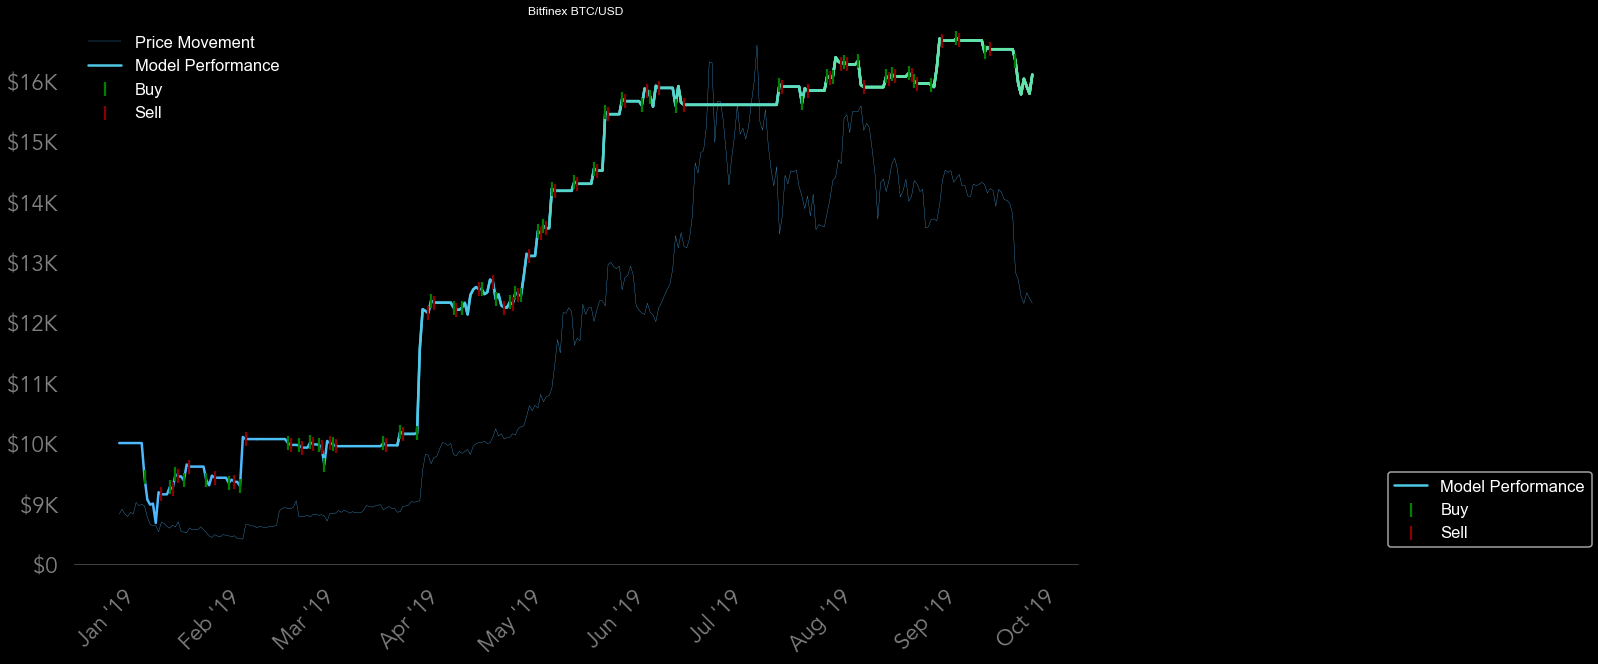

In [256]:
# Using Seaborn for Visuals

# making subplot and setting figure size
fig, ax = plt.subplots(figsize=(18, 10))
sns.set(style="ticks", context="talk")

# Black Backgorund
plt.style.use("dark_background")

# using these color palette for lineplot
flatui = ['#4eb9ff', '#4bc1f6', '#4fc9e5', '#57d5c7', '#5dddb9', '#63e4a7']

# setting y_limit for this model
plt.ylim(8000,17000)

# setting y-tick label to money format
ax.set_yticklabels(labels=['$0  ', '$9K  ', '$10K  ', '$11K  ', '$12K  ', '$13K  ', '$14K  ', '$15K  ', '$16K  ']);

# formating datetime for x-axis tick labels
myFmt = mdates.DateFormatter("%b '%y    ")

# creating 6 lineplot using the same data but sliced, This allows me to use all 6 colors on the line
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][:50], linewidth=2.5);
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][49:], linewidth=2.5);
sns.set_palette(flatui)

# Gave this line a label for the legend
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][99:], linewidth=2.5, ax=ax, label='Model Performance');
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][150:], linewidth=2.5);
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][199:], linewidth=2.5);
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['bitfinex_btc_usd'][250:], linewidth=2.5);

# creating 2 regplot to show the buy/sell indicators for our models performance
ax3 = sns.regplot(x='date', y='buy', data=df, marker="|", fit_reg=False, scatter_kws={"zorder":10, "color":"green","alpha":1,"s":200}, label='Buy');
ax3 = sns.regplot(x='date', y='sell', data=df, marker="|", fit_reg=False, scatter_kws={"zorder":10, "color":"darkred","alpha":1,"s":200}, label='Sell');

# creating a line plot to overlay the previous lineplot
p_color = ['#616161']
ax2 = plt.twinx()
# shows the cryptocurrency price change
ax2 = sns.lineplot(x = 'date', y='open', data=df_dict['bitfinex_btc_usd'], linewidth=.3, ax=ax2, label='Price Movement', legend=False);

# gets rid of left border 
sns.despine(left=True)

# get rid of '-' on axis
ax.tick_params(axis=u'both', which=u'both',length=0)
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax3.tick_params(axis=u'both', which=u'both',length=0)

# setting 2nd ax lineplot y tick labels blank
ax2.set_yticklabels(labels=['', '', '', '', '', '', '', '']);

# setting plot y and x label blank
ax.set_ylabel('');
ax2.set_ylabel('');
ax.set_xlabel('');

# turn x-tick label to 45 degree angle
plt.setp(ax.get_xticklabels(), rotation=45)

# setting x-axis tick label to myFmt for both axis
ax.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_formatter(myFmt)

# changing x and y tick color to grey
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')

# changing bottom spine color grey and linewidth
ax.spines['bottom'].set_color('grey')
ax.spines['bottom'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(0.0)

# Changing both axes x-tick label font style  
for tick in ax.get_xticklabels():
    tick.set_fontname("avenir")
for tick in ax.get_yticklabels():
    tick.set_fontname("avenir")
    
for tick in ax2.get_xticklabels():
    tick.set_fontname("avenir")
for tick in ax2.get_yticklabels():
    tick.set_fontname("avenir")
    
# to get labels from both axes and return them into one legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# plot legend 
leg = plt.legend(lines2 + lines, labels2 + labels, loc='upper left')

# get rid of legend frame 
leg.get_frame().set_linewidth(0.0)

# remove the legent from plot, can't make it go away
ax.legend(loc='center left', bbox_to_anchor=(1.3, 0.1));


sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 8});

# set title
ax.set_title("Bitfinex BTC/USD", fontsize=12);

# save figure in png
fig.savefig("bitfinex_btc_usd.png")

# 2.0 buy, 1.0 hold, -1.0 nothing, -2 sell



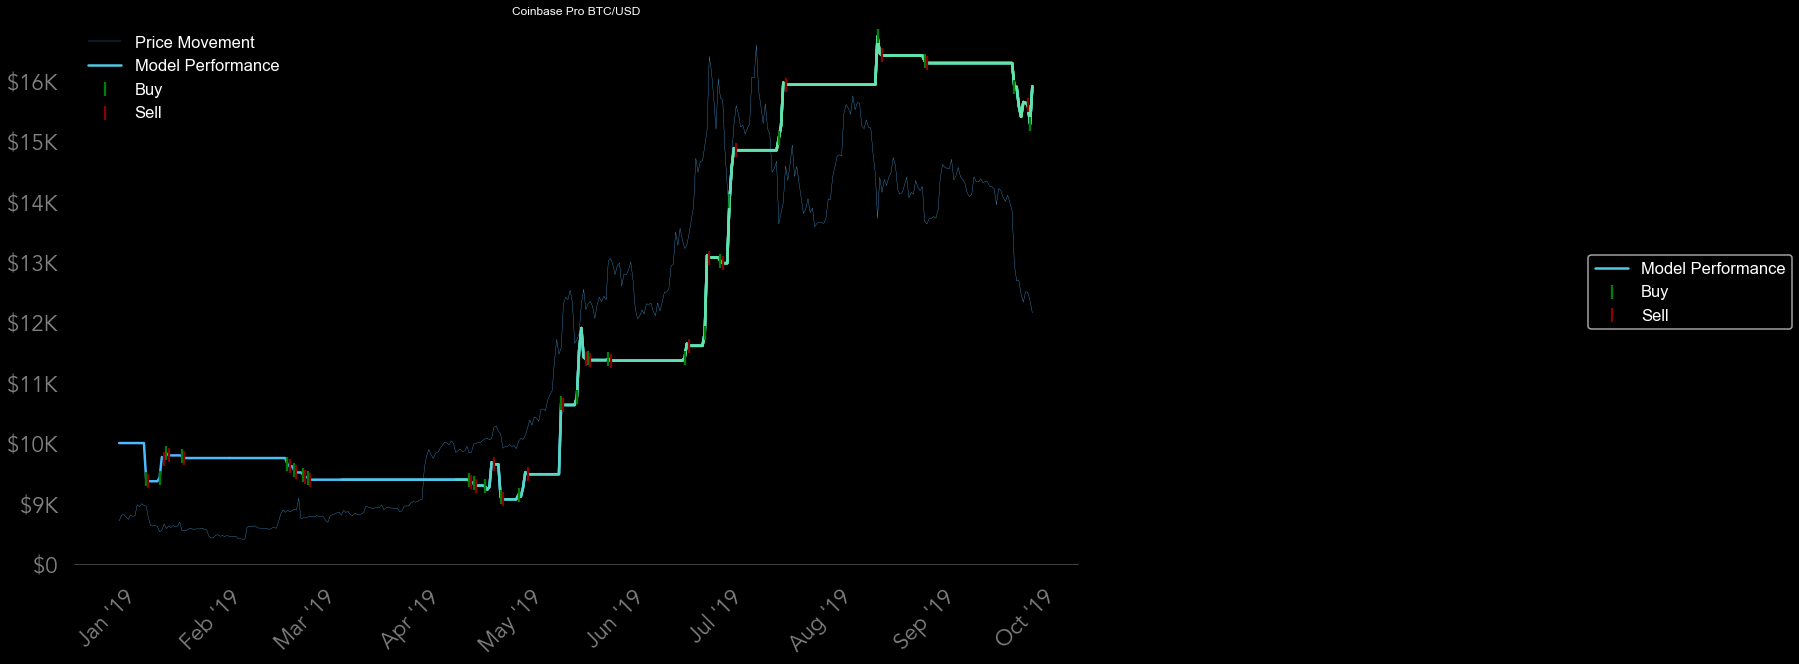

In [247]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

flatui = ['#4eb9ff', '#4bc1f6', '#4fc9e5', '#57d5c7', '#5dddb9', '#63e4a7']

plt.ylim(8000,17000)
ax.set_yticklabels(labels=['$0  ', '$9K  ', '$10K  ', '$11K  ', '$12K  ', '$13K  ', '$14K  ', '$15K  ', '$16K  ']);

myFmt = mdates.DateFormatter("%b '%y    ")

sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['coinbase_pro_btc_usd'][:50], linewidth=2.5);
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['coinbase_pro_btc_usd'][49:], linewidth=2.5);
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['coinbase_pro_btc_usd'][99:], linewidth=2.5, ax=ax, label='Model Performance');
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['coinbase_pro_btc_usd'][150:], linewidth=2.5);
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['coinbase_pro_btc_usd'][199:], linewidth=2.5);
sns.set_palette(flatui)
ax1 = sns.lineplot(x = 'date', y='my_money', data=df_dict['coinbase_pro_btc_usd'][250:], linewidth=2.5);

ax3 = sns.regplot(x='date', y='buy', data=df_dict['coinbase_pro_btc_usd'], marker="|", fit_reg=False, scatter_kws={"zorder":10, "color":"green","alpha":1,"s":200}, label='Buy');
ax3 = sns.regplot(x='date', y='sell', data=df_dict['coinbase_pro_btc_usd'], marker="|", fit_reg=False, scatter_kws={"zorder":10, "color":"darkred","alpha":1,"s":200}, label='Sell');
p_color = ['#616161']
ax2 = plt.twinx()

ax2 = sns.lineplot(x = 'date', y='open', data=df_dict['coinbase_pro_btc_usd'], linewidth=.3, ax=ax2, label='Price Movement');

sns.despine(left=True)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_yticklabels(labels=['', '', '', '', '', '', '', '']);

ax.set_ylabel('');
ax2.set_ylabel('');
ax.set_xlabel('');
plt.setp(ax.get_xticklabels(), rotation=45)

ax.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_formatter(myFmt)

ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
ax.spines['bottom'].set_color('grey')
ax.spines['bottom'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(0.0)

for tick in ax.get_xticklabels():
    tick.set_fontname("avenir")
for tick in ax.get_yticklabels():
    tick.set_fontname("avenir")
    
for tick in ax2.get_xticklabels():
    tick.set_fontname("avenir")
for tick in ax2.get_yticklabels():
    tick.set_fontname("avenir")
    
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
leg = plt.legend(lines2 + lines, labels2 + labels, loc='upper left')
leg.get_frame().set_linewidth(0.0)

ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))

sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 8})

ax.set_title("Coinbase Pro BTC/USD", fontsize=12);
fig.savefig("cbp_btc_usd.png")

